In [638]:
from imutils.object_detection import non_max_suppression
import numpy as np
import cv2
import pytesseract
import matplotlib.pyplot as plt
%matplotlib inline

In [639]:
image = cv2.imread('./opencv-text-detection/images/Book_Cover.png')
orig = image.copy()
for_text = image.copy()
for_text = cv2.cvtColor( for_text, cv2.COLOR_BGR2GRAY )
for_text = cv2.GaussianBlur( for_text, (1,1), 0 )

In [640]:
(H, W) = image.shape[:2]
(newW, newH) = (480, 320)
rW = W / float(newW)
rH = H / float(newH)

In [641]:
## Resize image ... Should be a multiple of 32
image = cv2.resize(image, (newW, newH))
(H,W) = image.shape[:2] 

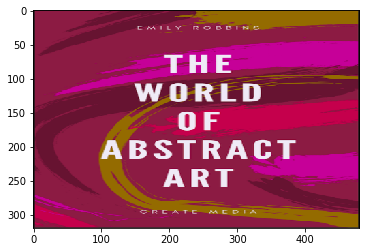

In [642]:
plt.imshow(image)
plt.show()

In [643]:
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

In [644]:
print ('Loading EAST Text Detector ... ')
net = cv2.dnn.readNet('./opencv-text-detection/frozen_east_text_detection.pb')

Loading EAST Text Detector ... 


In [645]:
print ('Preparing for Forward Pass')
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    (123.68, 116.78, 103.94), swapRB=True, crop=False)

net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

Preparing for Forward Pass


In [646]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

In [647]:
for y in range(0, numRows):
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    
    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.8:
            continue
 
        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)
         
        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
 
        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
 
        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
 
        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [648]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
orig_cord = []

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW) 
    endY = int(endY * rH) 
    
    orig_cord.append( (startX, startY, endX, endY) )
 
    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

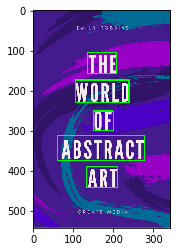

In [649]:
orig = cv2.cvtColor( orig, cv2.COLOR_BGR2RGB )
plt.imshow(orig)
plt.show()

In [650]:
orig_cord = sorted( orig_cord, key= lambda x : x[1] )

In [651]:
def process_img(img):
    img = cv2.threshold(img ,210,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    img = cv2.GaussianBlur( img, (1,1), 0)
    return img

In [652]:
def put_label(img, lbl, cord):
    startX, startY, endX, endY = cord
    cv2.rectangle(img, (startX-1, startY), (endX - 1, startY-20), (0, 255, 0), cv2.FILLED)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, lbl, (startX+5, startY-5), font, 0.5,
                (255, 255, 255), 1, cv2.LINE_AA)

In [653]:
ans = ""
for i in orig_cord:
    startX, startY, endX, endY = i
    
    req_image = for_text[ startY:endY, startX:endX ].copy()
    req_image = process_img( req_image )
    
    text = pytesseract.image_to_string( req_image )
    if ( len(text) > 0 ):
        ans += text + '\n'
        put_label( orig, text, i )
        


In [654]:
print ans

THE
WORLD
ABSTRACT
ART



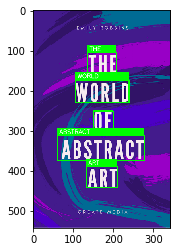

In [655]:
plt.imshow( orig )
plt.show()

In [656]:
# cv2.imshow( "Result", orig )
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## Test

WORLD


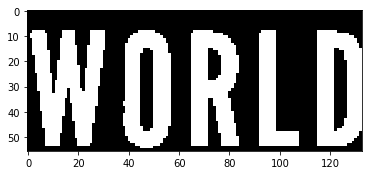

In [657]:
r = orig_cord[1]
startX, startY, endX, endY = r
req_image = for_text[ startY:endY, startX:endX ].copy()
req_image = process_img( req_image )
plt.imshow( req_image, cmap = 'gray' )
text = pytesseract.image_to_string( req_image )
print text
plt.show()